### Basic ipython notebook import 

In [2]:
# plot within the notebook
%matplotlib notebook
import warnings
# No annoying warnings
warnings.filterwarnings('ignore')
# Because we always need that
import numpy as np

***
# Tutorial:  Fit a Step

We are going to use scipy to create a data sample having a step, i.e. a y-offset at a given x-value. 
The data will be the combination of two samples of 100 element each:

* Sample "a": x-values between 0 and 10 having y-values normally distributed around -0.5 with a dispersion of 0.6. For each data points, we also add a y-error of 0.3.

* Sample "b": x-values between 10 and 20 having y-values normally distributed around 0.7 with a dispersion of 0.7. For each data points, we also add a y-error of 0.4.


## 1) Creation of the data points

In [81]:
# Structure of the _data: [x,y,yerr]
npointa,npointb = 100,100
adata = np.asarray([np.random.rand(npointa)*10, 
                    np.random.normal(loc=-0.07, scale=0.11, size=npointa), 
                    [0.10]*npointa])
bdata = np.asarray([np.random.rand(npointb)*10+10, 
                    np.random.normal(loc=0.07,scale=0.11,size=npointb), 
                    [0.11]*npointb])


Let's see how it looks like

<IPython.core.display.Javascript object>


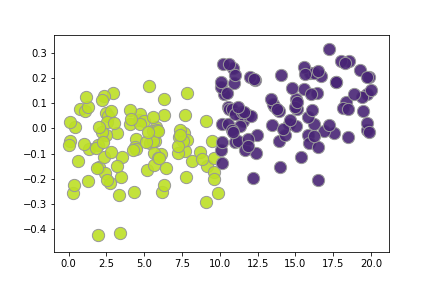

In [9]:
import matplotlib.pyplot as mpl
prop = dict(s=150, edgecolors="0.6")
mpl.scatter(adata[0],adata[1], facecolors=mpl.cm.viridis_r(0.1,0.9),**prop)
mpl.scatter(bdata[0],bdata[1], facecolors=mpl.cm.viridis_r(0.9,0.9),**prop)

## 2) Load modefit and set the Fitter object

In [10]:
import modefit

### Load the stepfit object that enables the fit


**Here is `stepfit` initialization doc:**

```
modefit.stepfit(x, data, errors, proba=None, dx=None, xcut=None, masknan=True, names=None, **kwargs)

Fit a Step in you Data !
This function will return a StepFit object that will allow you
to fit a step in you data and easily analysis this step.

Parameters
----------
x: [array]
    The x-axis of you data that will be used to define which point is
    above or below the given xcut value.
    If proba if provided, this will only be used for plotting.

data, errors: [array, array]
    The y-axis data (and its errors) that potentially is bimodal.


proba: [array] -optional-
    If you already know the probability for each point to be below (0) or
    above (1) the step, them give it here.

dx: [array] -optional-
    If proba is None, dx (the error on the x-axis) will enable to measure the
    probability to be above or below the step (at x=xcut).
    If proba is None and dx is None, the proba will be ones and zeros.

xcut: [float] -optional / required if proba is None -
    Define where the step is located.
    If proba is given, this will only be used for plotting

masknan: [bool] -optional-
    Remove the nan values (in x, data or errors) prior to load StepFit

names: [array] -optional-
    names for the data points.

Returns
-------
StepFit
```


In [12]:
x = np.concatenate([adata[0],bdata[0]])
y = np.concatenate([adata[1],bdata[1]])
dy = np.concatenate([adata[2],bdata[2]])
step = modefit.stepfit(x,y,dy,xcut = 10)

## 3) Fit the data

To perform the fit and you should provide the initial conditions. 

For each free parameter "x", there is 3 inputs you can set (you do not have to):

* x`_guess` : initial guess for the "x" parameter
* x`_boundaries`: fit boundaries for the "x" parameter
* x`_fixed`: Set this to True to fixe the parameter to its `_guess` value


In [13]:
step.fit(sigma_a_guess=0.5,sigma_b_guess=0.5, mean_a_guess=-.5,mean_b_guess=0.5)

Now that fit has been performed, you best fitted values will be displayed in the plot

<IPython.core.display.Javascript object>


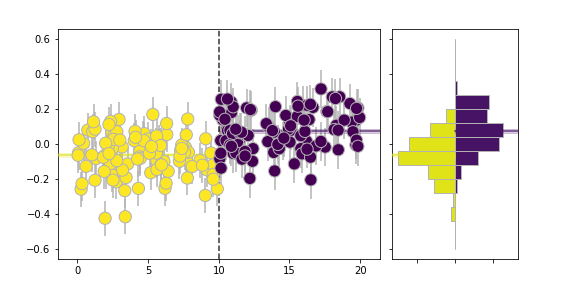

{'ax': [<matplotlib.axes._axes.Axes at 0x10d328190>,
  None,
 'fig': <matplotlib.figure.Figure at 0x10d3e8b50>}

In [15]:
step.show(rangey=[-0.6,0.6], binsy=15)

In [16]:
print step.modelstep

(-0.14175160106729234, 0.016293385396533178)


# MCMC approach

A mcmc package is included in the models and fitter. By default, the prior information are flat (no prior information). Change that by inheriting the class to create your own!

*this is slower*

In [19]:
step.run_mcmc(1000)

-> emcee EmsembleSampler defined
-> MCMC sampler.run_mcmc() done


<IPython.core.display.Javascript object>


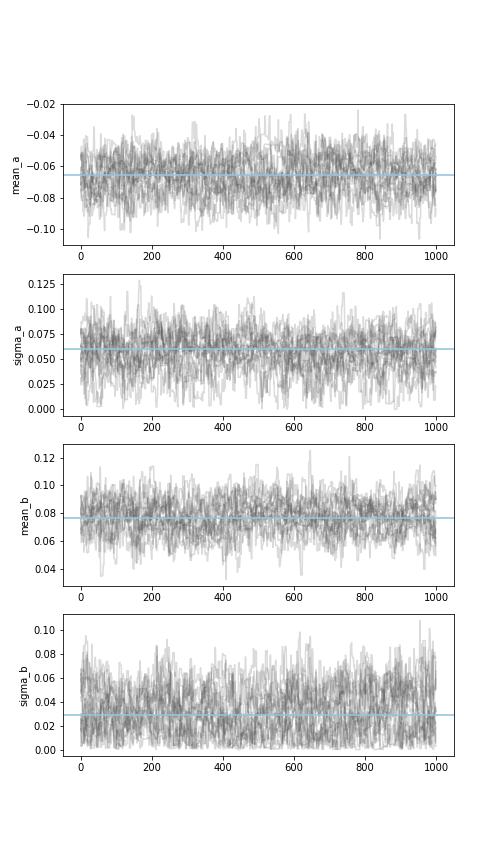

In [20]:
step.mcmc.show_walkers()

<IPython.core.display.Javascript object>


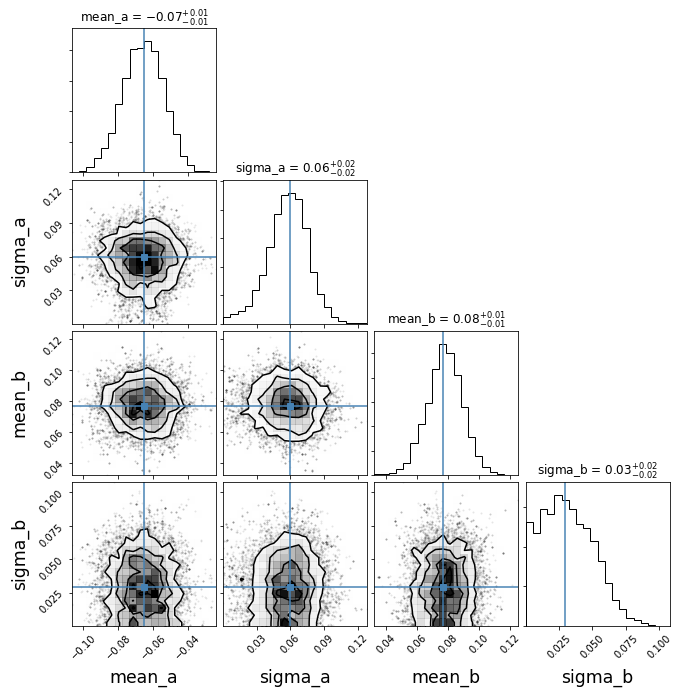

In [21]:
step.mcmc.set_burnin(10)
step.mcmc.show_corner()

***
# Comparison with Unimodal fit

In [11]:
step.set_unimodal()

In [12]:
step.unimodal.run_mcmc(1000)

-> emcee EmsembleSampler defined
-> MCMC sampler.run_mcmc() done


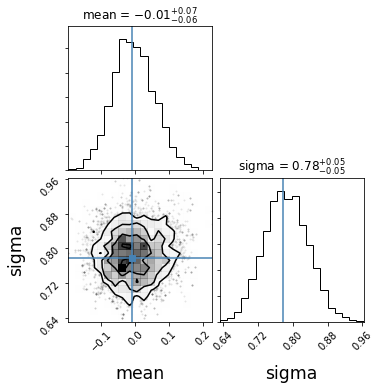

In [13]:
step.unimodal.mcmc.set_burnin(10)
step.unimodal.mcmc.show_corner()

# Error on Classification

In [22]:
proba = (x>10)

In [24]:
npointa, npointb

(100, 100)

In [82]:
def get_step_contamination(xchanged, get_step=False):
    xa,xb = np.arange(npointa), np.arange(npointb)
    np.random.shuffle(xa) ; np.random.shuffle(xb)
    index_changed_a_to_b = xa[:xchanged]
    index_changed_b_to_a = xb[:xchanged]
    x = np.concatenate([adata[0],bdata[0]])
    y = np.concatenate([adata[1],bdata[1]])
    proba = np.asarray(x<10, dtype="int")
    proba[index_changed_a_to_b] = 0
    proba[index_changed_b_to_a+npointa] = 1
    dy = np.concatenate([adata[2],bdata[2]])
    stepchanged = modefit.stepfit(x,y,dy,xcut = 10, proba=proba)
    stepchanged.fit()
    if not get_step:
        return stepchanged.modelstep
    return stepchanged.modelstep, stepchanged

In [83]:
steps_ = np.asarray([get_step_contamination(x_) for x_ in range(50)])

<IPython.core.display.Javascript object>


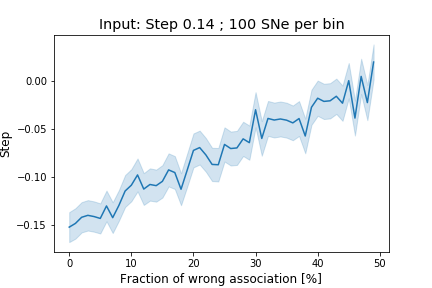

In [89]:
fig = mpl.figure(figsize=[6,4])
ax  = fig.add_subplot(111)
xx = np.arange(50)
ax.plot(xx, steps_.T[0])
ax.fill_between(xx, steps_.T[0]-steps_.T[1], 
               steps_.T[0]+steps_.T[1],
               color="C0", alpha=0.2)
ax.set_ylabel("Step", fontsize="large")
ax.set_xlabel("Fraction of wrong association [%]", fontsize="large")
ax.set_title("Input: Step 0.14 ; 100 SNe per bin", fontsize="x-large")
fig.savefig("/Users/mrigault/snfgit/lssfr-paper/PLOTS/step_and_misassociation.pdf")

In [70]:
steps_, stepchanged = get_step_contamination(100, True)

<IPython.core.display.Javascript object>


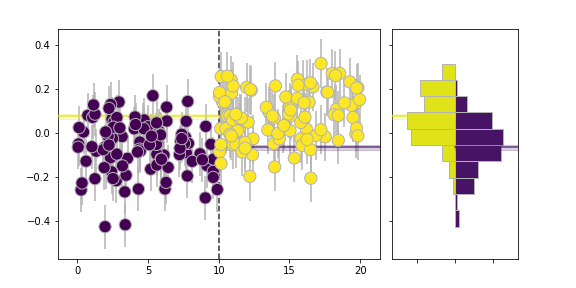

{'ax': [<matplotlib.axes._axes.Axes at 0x115210350>,
  None,
 'fig': <matplotlib.figure.Figure at 0x115225cd0>}

In [71]:
stepchanged.show()

In [ ]:
np.random